Saving test.jpg to test.jpg
Enter resize direction (horizontal/vertical): horizontal
Enter the number of seams to add/remove (positive to expand, negative to shrink, up to 10000): 100


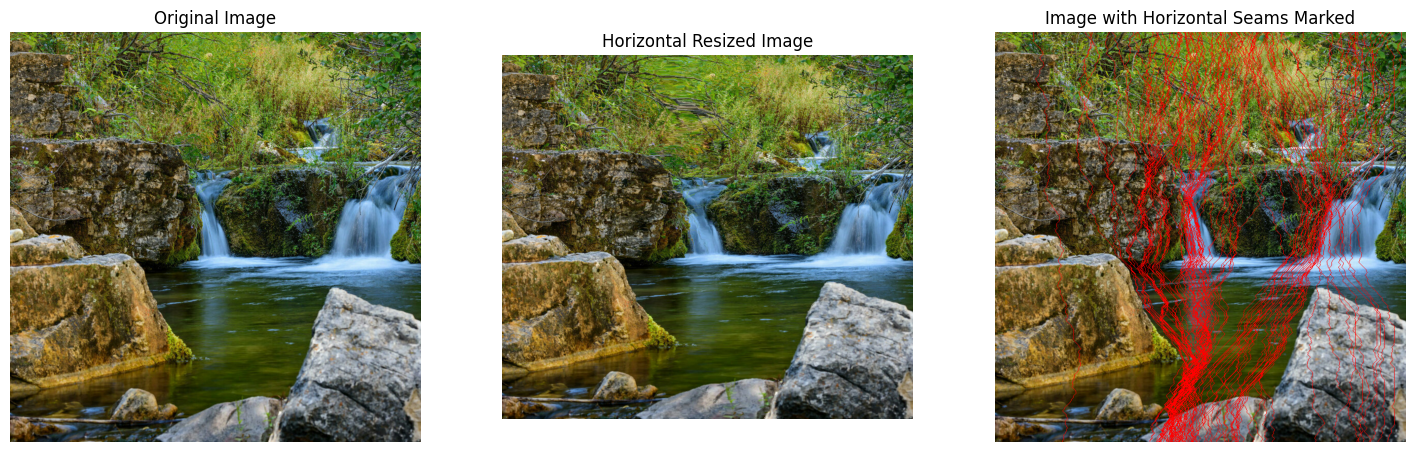

In [1]:
#Yara Wael Anwar 120210266
#Esraa Magdy ElHossiney 120210341
#Salma Hany ElShishtawy 120210255

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload an image manually in Colab
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get uploaded image name

def calcEnergy(img):
    # Calculate the gradients in x and y directions
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Take the absolute values of the gradients
    abs_grad_x = np.abs(grad_x)
    abs_grad_y = np.abs(grad_y)

    # Sum the absolute gradients to get the energy
    energy = abs_grad_x + abs_grad_y

    return energy

def carveColumns(img, num):
    count = 0
    color_img = img.copy()
    seams = []  # To store the seams removed

    while count < num:
        count += 1
        img_gray = cv2.cvtColor(np.uint8(color_img), cv2.COLOR_BGR2GRAY)
        img_gray = np.double(img_gray)
        EnergyImg = calcEnergy(img_gray)
        cumsumEnergy = np.zeros(EnergyImg.shape)
        PathMatrix = np.zeros(EnergyImg.shape)
        rows, cols = EnergyImg.shape

        cumsumEnergy[0, :] = EnergyImg[0, :]
        for i in range(1, rows):
            for j in range(cols):
                temp = [
                    99999 if j == 0 else cumsumEnergy[i - 1, j - 1],
                    cumsumEnergy[i - 1, j],
                    99999 if j == cols - 1 else cumsumEnergy[i - 1, j + 1]
                ]
                cumsumEnergy[i, j] = EnergyImg[i, j] + min(temp)
                PathMatrix[i, j] = temp.index(min(temp))

        startIndex = np.argmin(cumsumEnergy[-1])
        currIndex = startIndex
        final_b, final_g, final_r = [], [], []
        seam = []  # To store the current seam

        for i in range(rows - 1, -1, -1):
            row_b, row_g, row_r = color_img[i, :, 0], color_img[i, :, 1], color_img[i, :, 2]
            out_b, out_g, out_r = np.delete(row_b, currIndex), np.delete(row_g, currIndex), np.delete(row_r, currIndex)
            final_b.append(out_b)
            final_g.append(out_g)
            final_r.append(out_r)

            # Store the seam pixel
            seam.append((i, currIndex))

            if PathMatrix[i, currIndex] == 0:
                currIndex -= 1
            elif PathMatrix[i, currIndex] == 2:
                currIndex += 1

        r, c = len(final_b), len(final_b[0])
        temp_final = np.zeros((r, c, 3))
        temp_final[:, :, 0] = final_b
        temp_final[:, :, 1] = final_g
        temp_final[:, :, 2] = final_r
        color_img = np.flipud(np.array(temp_final))

        # Store the seam
        seams.append(seam)

    return color_img, seams

def insertColumns(img, num):
    # Find the optimal seams to duplicate
    temp_img = img.copy()
    seams_to_insert = []
    for _ in range(num):
        img_gray = cv2.cvtColor(np.uint8(temp_img), cv2.COLOR_BGR2GRAY)
        img_gray = np.double(img_gray)
        EnergyImg = calcEnergy(img_gray)
        cumsumEnergy = np.zeros(EnergyImg.shape)
        PathMatrix = np.zeros(EnergyImg.shape)
        rows, cols = EnergyImg.shape

        cumsumEnergy[0, :] = EnergyImg[0, :]
        for i in range(1, rows):
            for j in range(cols):
                temp = [
                    99999 if j == 0 else cumsumEnergy[i - 1, j - 1],
                    cumsumEnergy[i - 1, j],
                    99999 if j == cols - 1 else cumsumEnergy[i - 1, j + 1]
                ]
                cumsumEnergy[i, j] = EnergyImg[i, j] + min(temp)
                PathMatrix[i, j] = temp.index(min(temp))

        startIndex = np.argmin(cumsumEnergy[-1])
        currIndex = startIndex
        seam = []  # To store the current seam

        for i in range(rows - 1, -1, -1):
            seam.append((i, currIndex))
            if PathMatrix[i, currIndex] == 0:
                currIndex -= 1
            elif PathMatrix[i, currIndex] == 2:
                currIndex += 1

        seams_to_insert.append(seam)
        # Remove the seam temporarily to find the next optimal seam
        temp_img, _ = carveColumns(temp_img, 1)

    # Insert the seams
    for seam in seams_to_insert:
        rows, cols, _ = img.shape
        new_img = np.zeros((rows, cols + 1, 3))
        for i in range(rows):
            col = seam[i][1]
            new_img[i, :col + 1] = img[i, :col + 1]
            new_img[i, col + 1] = img[i, col]  # Duplicate the pixel
            new_img[i, col + 2:] = img[i, col + 1:]
        img = new_img

    return img, seams_to_insert  # Return both the expanded image and the seams

def carveRows(img, num):
    # Rotate the image 90 degrees to treat rows as columns
    img_rotated = np.rot90(img, 1)
    carved_img, seams = carveColumns(img_rotated, num)
    # Rotate the image back to its original orientation
    carved_img = np.rot90(carved_img, 3)
    return carved_img, seams

def insertRows(img, num):
    # Rotate the image 90 degrees to treat rows as columns
    img_rotated = np.rot90(img, 1)
    img_rotated, seams = insertColumns(img_rotated, num)
    # Rotate the image back to its original orientation
    img_rotated = np.rot90(img_rotated, 3)
    return img_rotated, seams

def markSeams(img, seams):
    img_with_seams = np.uint8(img.copy())
    for seam in seams:
        for (row, col) in seam:
            img_with_seams[row, col] = [0, 0, 255]  # Mark seam in red
    return img_with_seams

# Load and process the image
img = cv2.imread(image_path)
img = np.double(img)

# Ask the user for resizing direction
resize_direction = input("Enter resize direction (horizontal/vertical): ").strip().lower()

# Ask the user for the number of seams to add/remove
num_seams = int(input("Enter the number of seams to add/remove (positive to expand, negative to shrink, up to 10000): "))
if abs(num_seams) > 10000:
    raise ValueError("Number of seams must be between -10000 and 10000.")

# Perform resizing based on user input
if resize_direction == "horizontal":
    if num_seams > 0:
        output, seams = insertColumns(img, num_seams)  # Get the seams
        output = cv2.cvtColor(np.uint8(output), cv2.COLOR_BGR2RGB)
        img_with_seams = markSeams(img, seams)  # Mark the seams on the original image
        img_with_seams = cv2.cvtColor(img_with_seams, cv2.COLOR_BGR2RGB)
    else:
        output, seams = carveColumns(img, -num_seams)
        img_with_seams = markSeams(img, seams)
        output = cv2.cvtColor(np.uint8(output), cv2.COLOR_BGR2RGB)
        img_with_seams = cv2.cvtColor(img_with_seams, cv2.COLOR_BGR2RGB)
elif resize_direction == "vertical":
    if num_seams > 0:
        output, seams = insertRows(img, num_seams)  # Get the seams
        output = cv2.cvtColor(np.uint8(output), cv2.COLOR_BGR2RGB)
        img_with_seams = markSeams(img, seams)  # Mark the seams on the original image
        img_with_seams = cv2.cvtColor(img_with_seams, cv2.COLOR_BGR2RGB)
    else:
        output, seams = carveRows(img, -num_seams)
        img_with_seams = markSeams(img, seams)
        output = cv2.cvtColor(np.uint8(output), cv2.COLOR_BGR2RGB)
        img_with_seams = cv2.cvtColor(img_with_seams, cv2.COLOR_BGR2RGB)
else:
    raise ValueError("Invalid resize direction. Choose 'horizontal' or 'vertical'.")

# Display the original, carved/expanded, and seam-marked images
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
ax[0].imshow(cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis("off")

# Carved/Expanded Image
ax[1].imshow(output)
ax[1].set_title(f"{resize_direction.capitalize()} Resized Image")
ax[1].axis("off")

# Image with Seams Marked
ax[2].imshow(img_with_seams)
ax[2].set_title(f"Image with {resize_direction.capitalize()} Seams Marked")
ax[2].axis("off")

plt.show()